In [1]:
import scarlink.src.chromatin_potential as scp
import matplotlib.pyplot as plt
import sklearn.preprocessing
import scanpy as sc
import anndata as ad
import scvelo as scv
import numpy as np
import pandas
import seaborn

## Mouse skin

#### Chromatin potential

In [2]:
def get_arrows(d_data, genes=[], max_per_cell=10, umap_key='umap',
                gene_corr_cutoff=0, n_arrows=500, min_count=5, **kwargs):

    batch = None
    #umap_key = 'umap'
    d = d_data.copy()
    if genes != []:
        d = scp.filter_genes(d, batch, genes)
    x, v, d, M = scp.chrom_pot(d, batch=batch, umap_key=umap_key, max_per_cell=max_per_cell,
                       metric='correlation', gene_corr_cutoff=gene_corr_cutoff,
                           scaling='minmax')
    return x, v

In [3]:
# SCARlink output directory
mouse_skin_dir = "mouse_skin_subset_10k/"
# UMAP coordinates
mouse_skin_umap = pandas.read_csv(mouse_skin_dir + "umap.csv", sep=',')[['umap1', 'umap2']].values
mouse_skin_chrom_p = scp.create_object(mouse_skin_dir, celltype_col='celltype', umap=mouse_skin_umap)

In [4]:
mouse_x, mouse_v = get_arrows(mouse_skin_chrom_p)

#### RNA velocity

Preprocessed spliced and unspliced counts `adata_postpro.h5ad` downloaded from https://figshare.com/ndownloader/files/40064275

In [5]:
adata_mouse_skin = sc.read_h5ad("/data/leslie/sneha/data/downloads/multivelo_files/adata_postpro.h5ad")
adata_mouse_skin = adata_mouse_skin[adata_mouse_skin.obs_names.str.replace(',', 
                                        '.').isin(mouse_skin_chrom_p['obs'].obs['cell_name_atac'].values)]
match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
adata_mouse_skin = adata_mouse_skin[match(mouse_skin_chrom_p['obs'].obs['cell_name_atac'].tolist(), 
         adata_mouse_skin.obs_names.str.replace(',', '.').tolist())]
mouse_skin_chrom_p['obs'].obsm['X_umap'] = mouse_skin_chrom_p['umap']
mouse_skin_chrom_p['celltype_col'] = 'celltype'

#### stochastic

In [6]:
scv.pp.filter_and_normalize(adata_mouse_skin)
scv.pp.moments(adata_mouse_skin)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/72 cores)


  0%|          | 0/6431 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


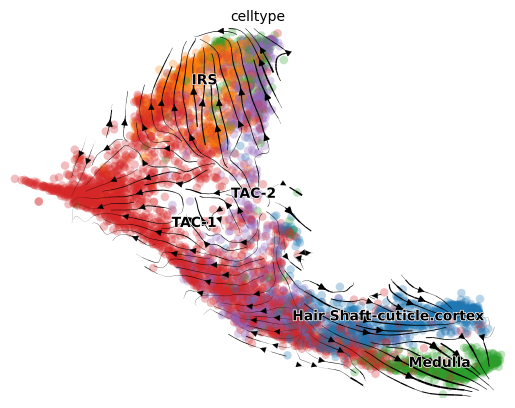

In [7]:
scv.tl.velocity(adata_mouse_skin, mode='stochastic')
scv.tl.velocity_graph(adata_mouse_skin, n_jobs=1)
scv.pl.velocity_embedding_stream(adata_mouse_skin, basis='umap', color='celltype')

In [8]:
def get_metrics(chrom_p_df, x_1, v_1, umap, v_umap):
    dist_c = np.sqrt(np.sum(v_1**2, axis=1))
    dist_s = np.sqrt(np.sum(v_umap**2, axis=1))
    dist_c = (dist_c-min(dist_c))/(max(dist_c)-min(dist_c))
    dist_s = (dist_s-min(dist_s))/(max(dist_s)-min(dist_s))

    cosines = np.zeros(x_1.shape[0])
    euclids = np.zeros(x_1.shape[0])

    for i in range(cosines.shape[0]):
        cosines[i] = sklearn.metrics.pairwise.cosine_similarity(np.array([x_1[i], v_1[i]]), 
                                          np.array([umap[i], 
                                         v_umap[i]]))[1, 1]
        euclids[i] = sklearn.metrics.pairwise.pairwise_distances(np.array([x_1[i], v_1[i]]), 
                                          np.array([umap[i], 
                                         v_umap[i]]))[1, 1]
    return cosines, euclids, dist_c, dist_s

In [14]:
def plot_metrics(adata, basis='umap', celltype_col='celltype', save=None):
    fig, ax = plt.subplots(1, 4, figsize=(25, 6))
    seaborn.boxplot(data=adata.obs, x=celltype_col, y='cosine', ax=ax[2], palette=adata.uns[celltype_col+'_colors'])
    seaborn.boxplot(data=adata.obs, x=celltype_col, y='dist_diff', ax=ax[3], palette=adata.uns[celltype_col+'_colors'])
    ax[2].tick_params(axis='x', rotation=90)
    ax[3].tick_params(axis='x', rotation=90)
    if basis=='umap': sc.pl.umap(adata, color='cosine', cmap='viridis', ax=ax[1], show=False)
    else: sc.pl.draw_graph(adata, color='cosine', cmap='viridis', ax=ax[1], show=False)
    seaborn.despine(ax=ax[1], left=True, bottom=True, trim=True)
    seaborn.despine(ax=ax[2])
    seaborn.despine(ax=ax[3])
    ax[2].set_ylabel("")
    ax[3].set_ylabel("")
    ax[0].axis('off')
    scv.pl.velocity_embedding_stream(adata.copy(), basis=basis, color=celltype_col, ax=ax[0], legend_loc='right margin', show=False)
    if save is not None:
        plt.tight_layout()
        plt.savefig('figures/' + save, transparent=True)
        print("Saved: figures/" + save)

In [10]:
mouse_skin_chrom_p_df = pandas.DataFrame(mouse_skin_chrom_p['obs'].obsm['X_umap'], 
                                  index=mouse_skin_chrom_p['obs'].obs['cell_name_atac'], 
                                    columns=['umap0', 'umap1'])
cosines, euclids, dist_c, dist_s = get_metrics(mouse_skin_chrom_p_df, mouse_x, mouse_v, adata_mouse_skin.obsm['X_umap'], 
                                               adata_mouse_skin.obsm['velocity_umap'])
adata_mouse_skin.obs['cosine'] = cosines
adata_mouse_skin.obs['euclid'] = euclids
adata_mouse_skin.obs['dist_diff'] = (dist_c - dist_s).tolist()

Saved: figures/mouse_skin_s.pdf


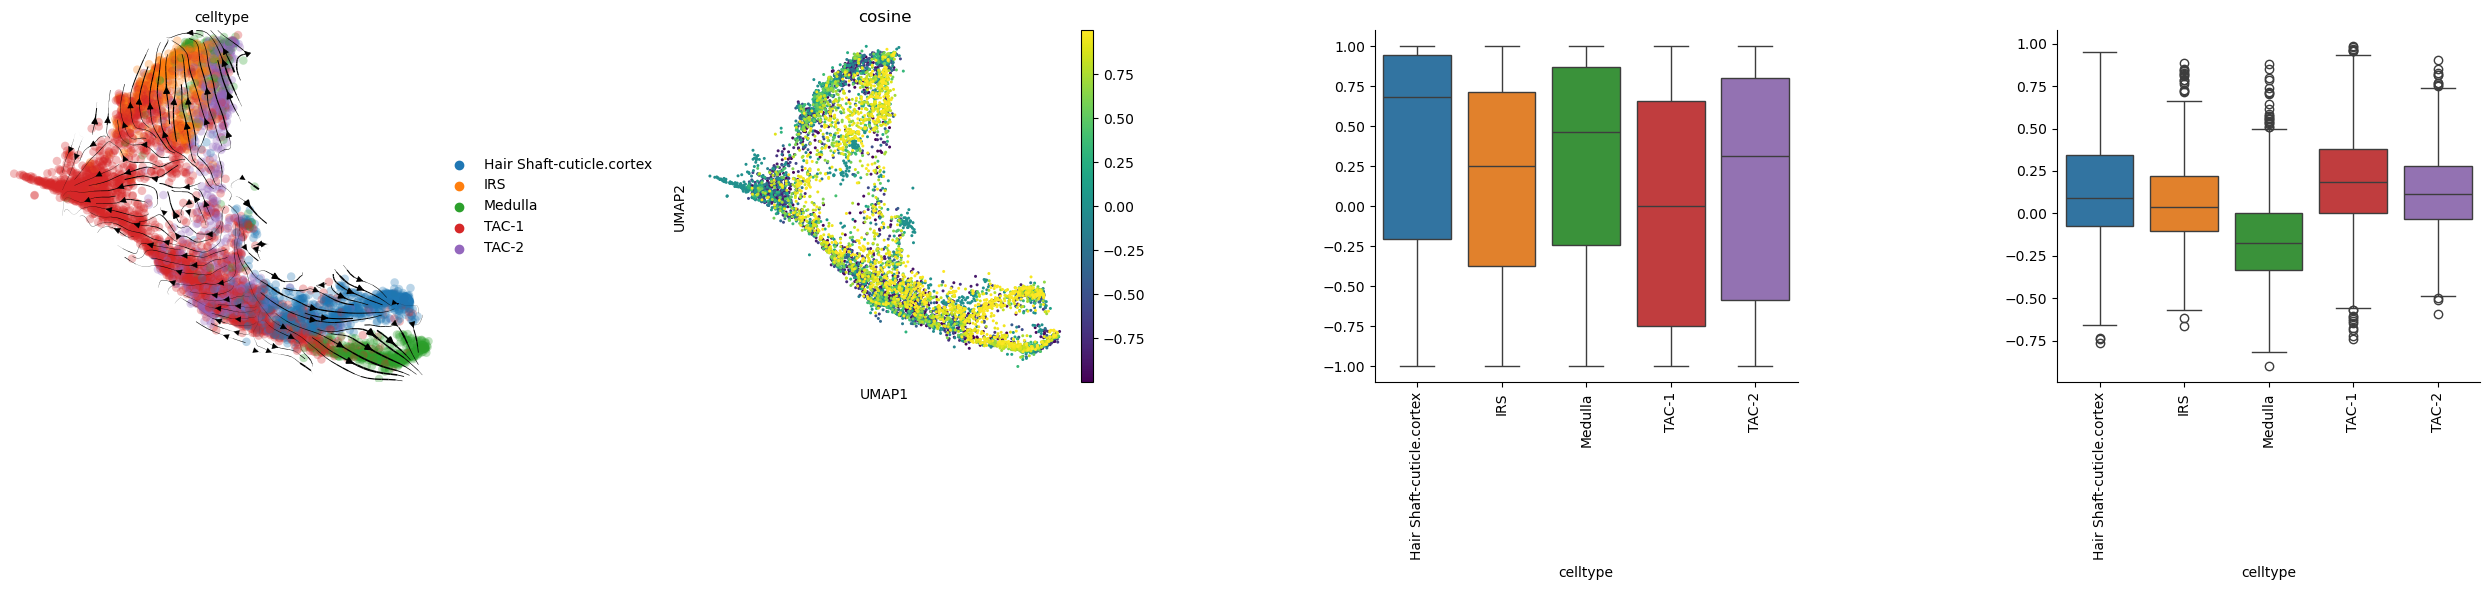

In [15]:
plot_metrics(adata_mouse_skin, save='mouse_skin_s.pdf')

#### dynamical

recovering dynamics (using 1/72 cores)


  0%|          | 0/105 [00:00<?, ?gene/s]

    finished (0:01:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/72 cores)


  0%|          | 0/6431 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


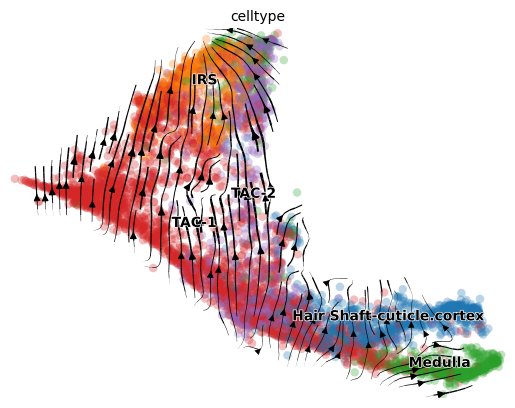

In [16]:
scv.tl.recover_dynamics(adata_mouse_skin)
scv.tl.velocity(adata_mouse_skin, mode='dynamical')
scv.tl.velocity_graph(adata_mouse_skin, n_jobs=1)
scv.pl.velocity_embedding_stream(adata_mouse_skin, basis='umap', color='celltype')

In [17]:
cosines, euclids, dist_c, dist_s = get_metrics(mouse_skin_chrom_p_df, mouse_x, mouse_v, adata_mouse_skin.obsm['X_umap'], 
                                               adata_mouse_skin.obsm['velocity_umap'])
adata_mouse_skin.obs['cosine'] = cosines
adata_mouse_skin.obs['euclid'] = euclids
adata_mouse_skin.obs['dist_diff'] = (dist_c - dist_s).tolist()

Saved: figures/mouse_skin_d.svg


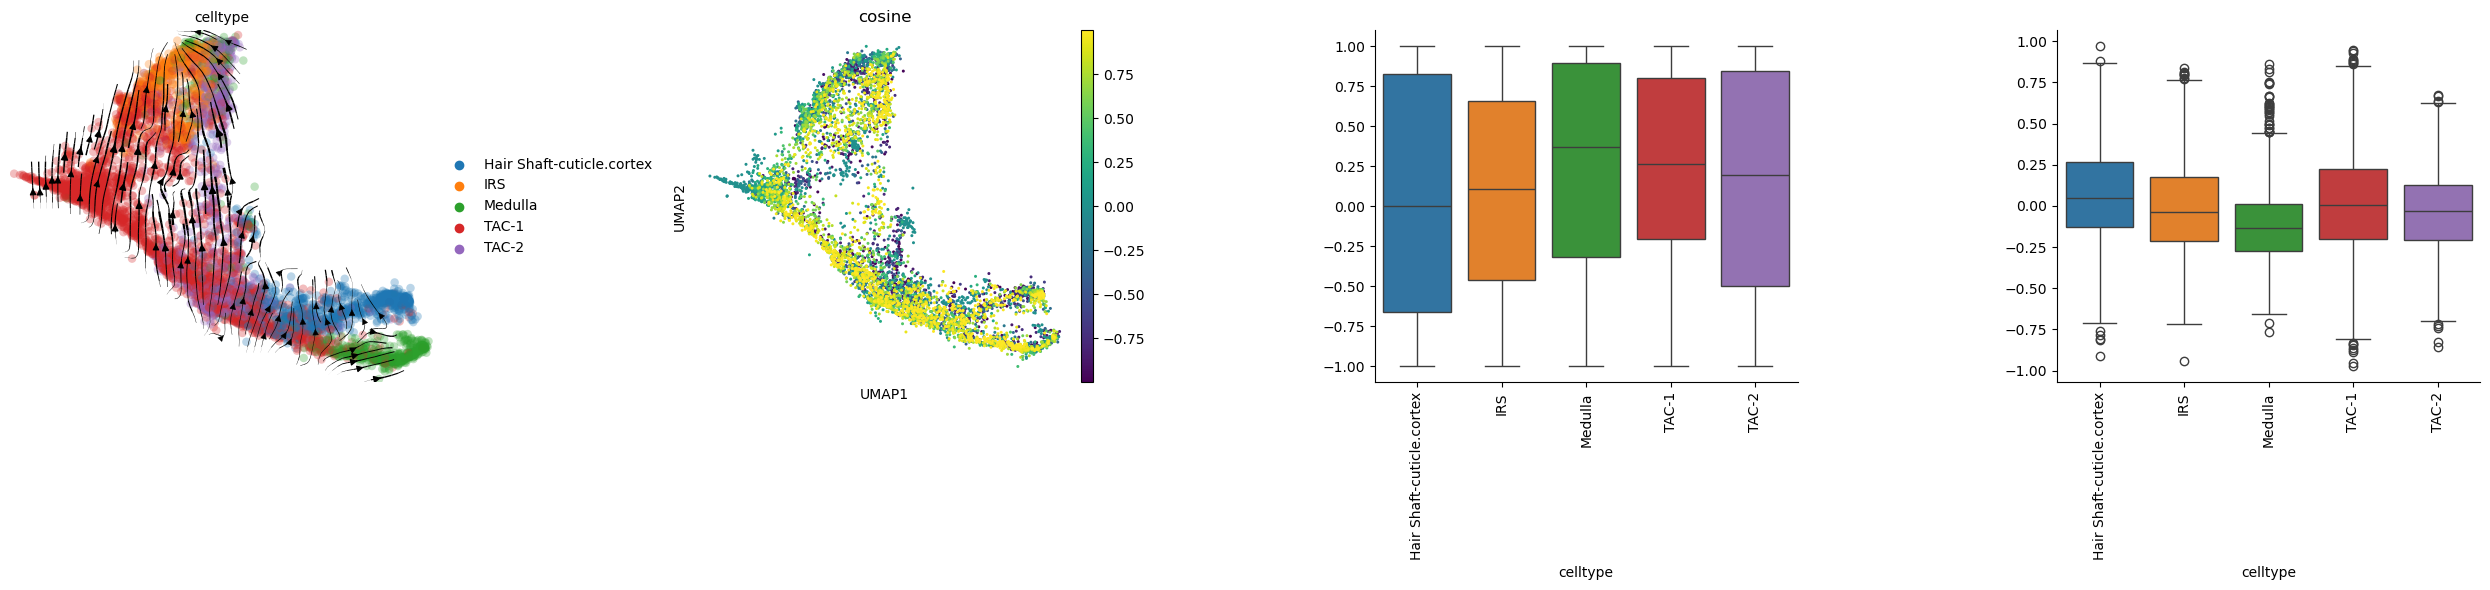

In [20]:
plot_metrics(adata_mouse_skin, save='mouse_skin_d.svg')

## Developing human cortex

#### Chromatin potential

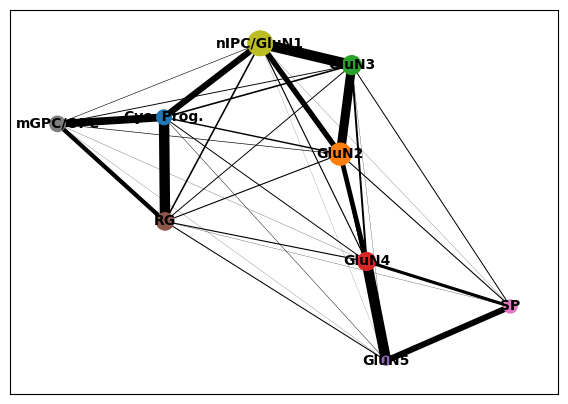

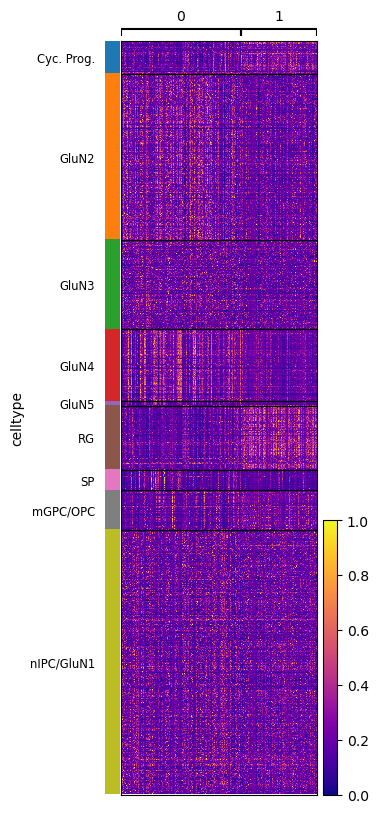

In [21]:
# SCARlink output directory
cortex_dir = "human_cortex_all_out_10k/"
# LSI file name 
cortex_lsi_file = cortex_dir + "scatac_LSI_50.csv"
cortex_cell_info = pandas.read_csv(cortex_dir + "cell_info.txt", sep='\t')
cortex_chrom_p = scp.create_object(cortex_dir, celltype_col='celltype', lsi_file=cortex_lsi_file)
# cluster genes
cortex_genes = scp.cluster_genes(cortex_chrom_p, n_clust=2)

In [22]:
cortex_x, cortex_v = get_arrows(cortex_chrom_p, genes=cortex_genes['1'], umap_key='draw_graph_fa')

#### RNA velocity

Preprocessed spliced and unspliced counts `human_brain_rna_after_filt_r2.h5ad` downloaded from https://figshare.com/ndownloader/files/40064350

In [23]:
rna_url = "https://figshare.com/ndownloader/files/40064350"
rna_path = "human_brain_rna_after_filt_r2.h5ad"
adata_human_cortex = sc.read(rna_path, backup_url=rna_url)

In [24]:
cortex_cell_info['cell_name'] = cortex_cell_info['cell_name'].str.replace("#", "_").str.rstrip('-1').values

In [25]:
human_cortex_chrom_p_df = pandas.DataFrame(cortex_chrom_p['obs'].obsm['X_draw_graph_fa'], index=cortex_cell_info['cell_name'].values, 
                                           columns=['umap0', 'umap1'])
human_cortex_chrom_p_df['x0'] = cortex_x[:, 0].copy()
human_cortex_chrom_p_df['x1'] = cortex_x[:, 1].copy()
human_cortex_chrom_p_df['v0'] = cortex_v[:, 0].copy()
human_cortex_chrom_p_df['v1'] = cortex_v[:, 1].copy()
adata_human_cortex = adata_human_cortex[adata_human_cortex.obs_names.isin(human_cortex_chrom_p_df.index.values)]
human_cortex_chrom_p_df = adata_human_cortex.obs.merge(human_cortex_chrom_p_df, left_index=True, right_index=True)
cortex_x = human_cortex_chrom_p_df[['x0', 'x1']].values
cortex_v = human_cortex_chrom_p_df[['v0', 'v1']].values
human_cortex_chrom_p_df = human_cortex_chrom_p_df[['umap0', 'umap1']]
adata_human_cortex.obsm['X_draw_graph_fa'] = human_cortex_chrom_p_df.values
adata_human_cortex.uns['draw_graph'] = cortex_chrom_p['obs'].uns['draw_graph'] 

human_cortex_cells = cortex_chrom_p['obs'].obs[['celltype']]
human_cortex_cells = human_cortex_cells.set_index(cortex_cell_info['cell_name'].values)
adata_human_cortex = adata_human_cortex[adata_human_cortex.obs_names.isin(human_cortex_cells.index.values)]
adata_human_cortex.obs = adata_human_cortex.obs.merge(human_cortex_cells, left_index=True, right_index=True)

#### stochastic

In [26]:
scv.pp.filter_and_normalize(adata_human_cortex) 
scv.pp.moments(adata_human_cortex, n_pcs = 30, n_neighbors = 30)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/72 cores)


  0%|          | 0/4602 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)


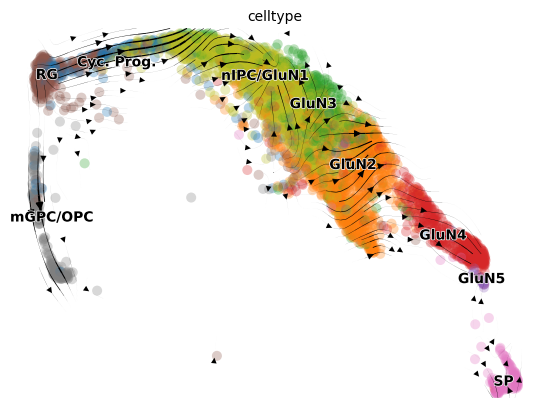

In [27]:
scv.tl.velocity(adata_human_cortex, mode='stochastic')
scv.tl.velocity_graph(adata_human_cortex, n_jobs=1)
scv.pl.velocity_embedding_stream(adata_human_cortex, basis='draw_graph_fa', color='celltype')

In [28]:
cosines, euclids, dist_c, dist_s = get_metrics(human_cortex_chrom_p_df, cortex_x, cortex_v, adata_human_cortex.obsm['X_draw_graph_fa'], 
                                               adata_human_cortex.obsm['velocity_draw_graph_fa'])
adata_human_cortex.obs['cosine'] = cosines
adata_human_cortex.obs['euclid'] = euclids
adata_human_cortex.obs['dist_diff'] = (dist_c - dist_s).tolist()

Saved: figures/human_cortex_s.svg


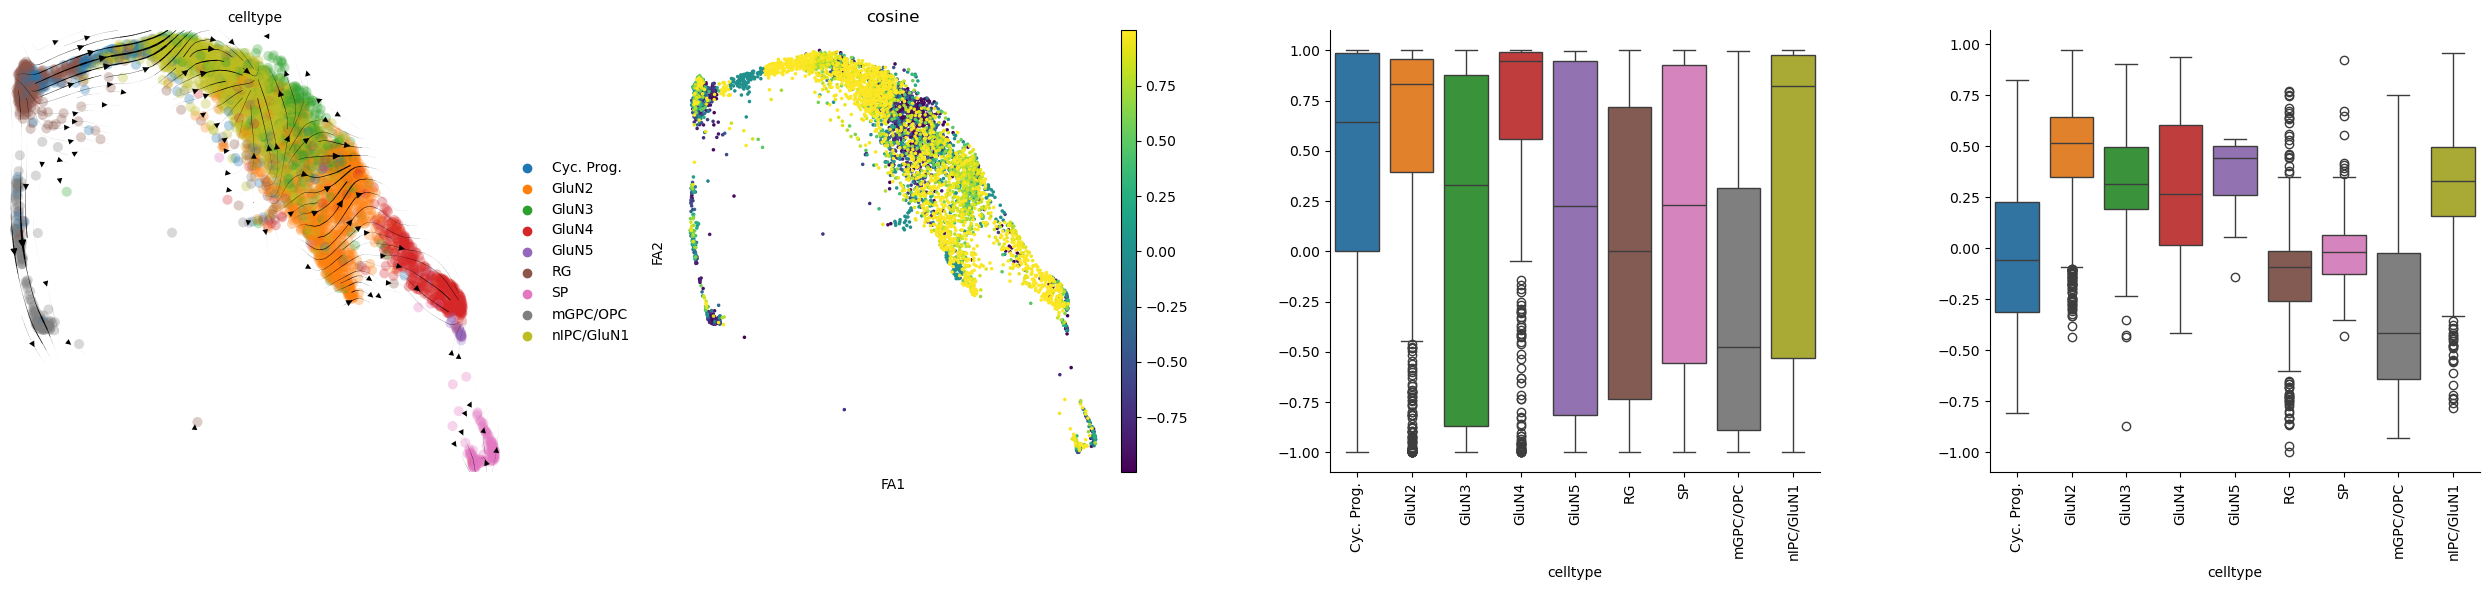

In [29]:
plot_metrics(adata_human_cortex, basis='draw_graph_fa', save='human_cortex_s.svg')

#### dynamical

recovering dynamics (using 1/72 cores)


  0%|          | 0/421 [00:00<?, ?gene/s]

    finished (0:03:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/72 cores)


  0%|          | 0/4602 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)


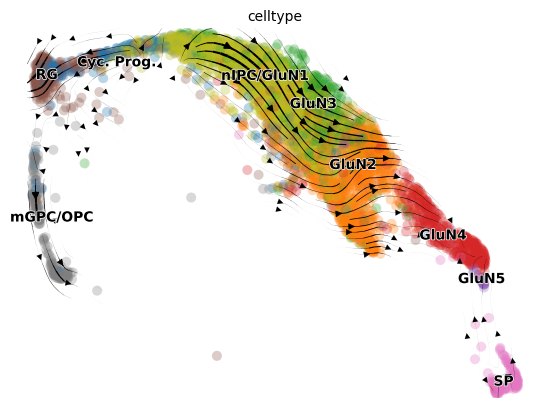

In [30]:
scv.tl.recover_dynamics(adata_human_cortex)
scv.tl.velocity(adata_human_cortex, mode='dynamical')
scv.tl.velocity_graph(adata_human_cortex, n_jobs=1)
scv.pl.velocity_embedding_stream(adata_human_cortex, basis='draw_graph_fa', color='celltype')

In [31]:
cosines, euclids, dist_c, dist_s = get_metrics(human_cortex_chrom_p_df, cortex_x, cortex_v, adata_human_cortex.obsm['X_draw_graph_fa'], 
                                               adata_human_cortex.obsm['velocity_draw_graph_fa'])
adata_human_cortex.obs['cosine'] = cosines
adata_human_cortex.obs['euclid'] = euclids
adata_human_cortex.obs['dist_diff'] = (dist_c - dist_s).tolist()

Saved: figures/human_cortex_d.svg


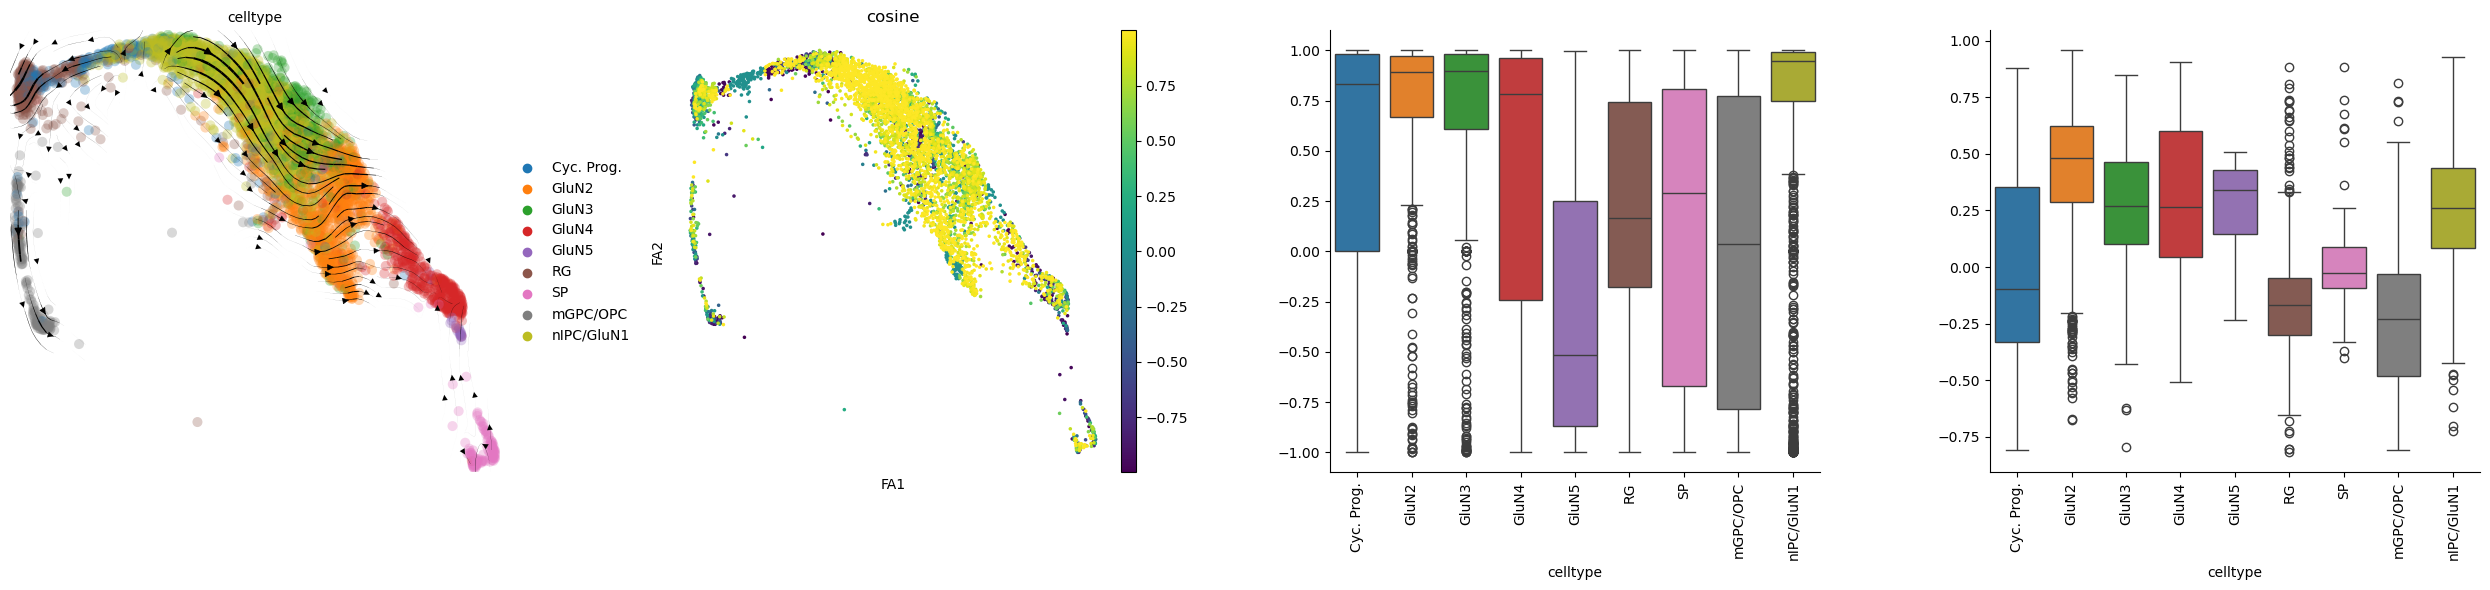

In [32]:
plot_metrics(adata_human_cortex, basis='draw_graph_fa', save='human_cortex_d.svg')

## BMMC

#### Chromatin potential

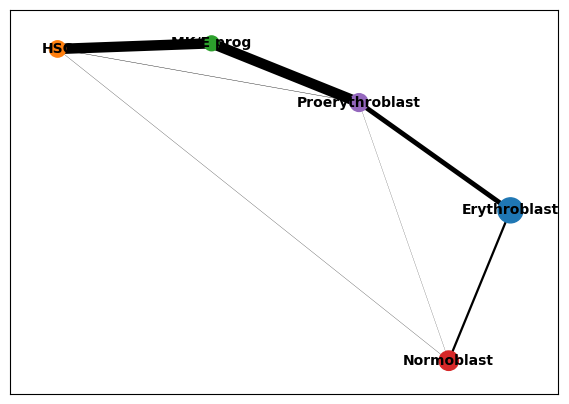

In [33]:
# SCARlink output directory
bmmc_dir = "bmmc_all_out_10k/"
# Separately saved list of top 2000 genes
bmmc_hvg2000 = pandas.read_csv(bmmc_dir + "hvg2000.txt", sep='\t', header=None)[0].values.tolist()
bmmc_chrom_p = scp.create_object(bmmc_dir, celltype_col='cell_type')

In [34]:
bmmc_x, bmmc_v = get_arrows(bmmc_chrom_p, genes=bmmc_hvg2000, umap_key='draw_graph_fa')

#### RNA velocity

Processed spliced and unspliced counts generated using velocyto

In [35]:
s1d1 = scv.read("/data/leslie/shared/BMMC_loom_files/site1_donor01_multiome_gex_S1C23.loom")
s1d1.obs_names = ['s1d1#' + x.split(":")[-1] + '-1' for x in s1d1.obs_names]
s2d1 = scv.read("/data/leslie/shared/BMMC_loom_files/site2_donor01_multiome_gex_7ZGWX.loom")
s2d1.obs_names = ['s2d1#' + x.split(":")[-1] + '-1' for x in s2d1.obs_names]
s2d4 = scv.read("/data/leslie/shared/BMMC_loom_files/site2_donor04_multiome_gex_MLWQF.loom")
s2d4.obs_names = ['s2d4#' + x.split(":")[-1] + '-1' for x in s2d4.obs_names]
s3d10 = scv.read("/data/leslie/shared/BMMC_loom_files/site3_donor10_multiome_gex_7R0GD.loom")
s3d10.obs_names = ['s3d10#' + x.split(":")[-1] + '-1' for x in s3d10.obs_names]
s1d1.var_names_make_unique()
s2d1.var_names_make_unique()
s2d4.var_names_make_unique()
s3d10.var_names_make_unique()

In [36]:
adata_bmmc = ad.concat([s1d1, s2d1, s2d4, s3d10], join="inner").copy()
adata_bmmc = adata_bmmc[adata_bmmc.obs_names.isin(bmmc_chrom_p['obs'].obs['cell_name'].values)]

In [37]:
bmmc_x = bmmc_x.copy()[bmmc_chrom_p['obs'].obs['cell_name'].isin(adata_bmmc.obs_names).values]
bmmc_v = bmmc_v.copy()[bmmc_chrom_p['obs'].obs['cell_name'].isin(adata_bmmc.obs_names).values]
bmmc_chrom_p['pred'] = bmmc_chrom_p['pred'][bmmc_chrom_p['pred'].obs['cell_name'].isin(adata_bmmc.obs_names)]
bmmc_chrom_p['obs'] = bmmc_chrom_p['obs'][bmmc_chrom_p['obs'].obs['cell_name'].isin(adata_bmmc.obs_names)]
human_cortex_chrom_p_df['x1'] = cortex_x[:, 1].copy()
human_cortex_chrom_p_df['v0'] = cortex_v[:, 0].copy()
human_cortex_chrom_p_df['v1'] = cortex_v[:, 1].copy()
fa = pandas.DataFrame(bmmc_chrom_p['obs'].obsm['X_draw_graph_fa'], columns=['fa1', 'fa2'], 
                      index=bmmc_chrom_p['obs'].obs[bmmc_chrom_p['obs'].obs['cell_name'].isin(adata_bmmc.obs_names)]['cell_name'].values)
fa['cell_type'] = bmmc_chrom_p['obs'].obs['cell_type'].values
fa = fa.merge(adata_bmmc.obs, how='inner', right_index=True, left_index=True)
adata_bmmc.obsm['X_draw_graph_fa'] = fa[['fa1', 'fa2']].values
adata_bmmc.obs['cell_type'] = fa['cell_type'].values
adata_bmmc.uns['draw_graph'] = bmmc_chrom_p['obs'].uns['draw_graph'] 

#### stochastic

In [38]:
scv.pp.filter_and_normalize(adata_bmmc) 
scv.pp.moments(adata_bmmc, n_pcs = 30, n_neighbors = 30)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


computing velocities
    finished (0:00:20) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/72 cores)


  0%|          | 0/5355 [00:00<?, ?cells/s]

    finished (0:00:29) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)


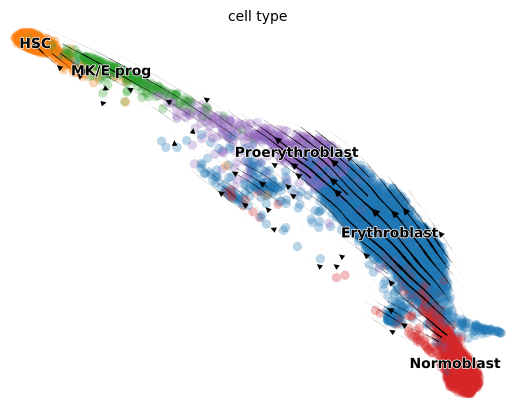

In [39]:
scv.tl.velocity(adata_bmmc, mode='stochastic')
scv.tl.velocity_graph(adata_bmmc, n_jobs=1)
scv.pl.velocity_embedding_stream(adata_bmmc, basis='draw_graph_fa', color='cell_type')

In [40]:
bmmc_chrom_p_df = pandas.DataFrame(bmmc_chrom_p['obs'].obsm['X_draw_graph_fa'], 
                                  index=bmmc_chrom_p['obs'].obs['cell_name'], 
                                    columns=['umap0', 'umap1'])
cosines, euclids, dist_c, dist_s = get_metrics(bmmc_chrom_p_df, bmmc_x, bmmc_v, adata_bmmc.obsm['X_draw_graph_fa'], 
                                               adata_bmmc.obsm['velocity_draw_graph_fa'])
adata_bmmc.obs['cosine'] = cosines
adata_bmmc.obs['euclid'] = euclids
adata_bmmc.obs['dist_diff'] = (dist_c - dist_s).tolist()

Saved: figures/bmmc_s.svg


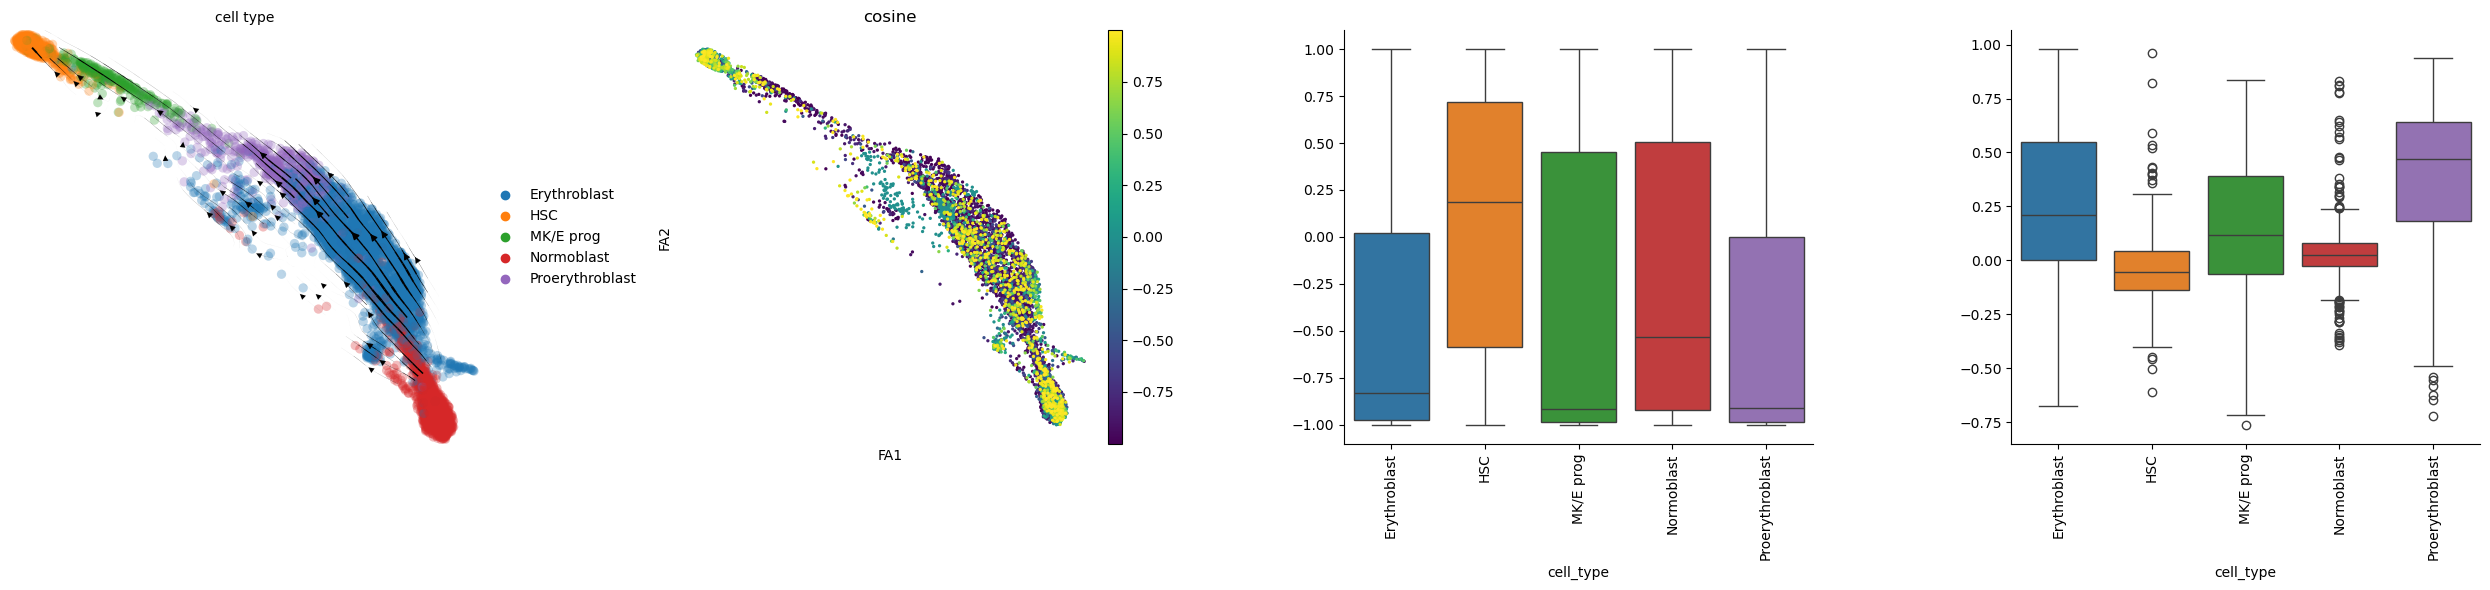

In [41]:
plot_metrics(adata_bmmc, basis='draw_graph_fa', celltype_col='cell_type', save='bmmc_s.svg')

#### dynamical

recovering dynamics (using 1/72 cores)


  0%|          | 0/1889 [00:00<?, ?gene/s]

    finished (0:12:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:29) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/72 cores)


  0%|          | 0/5355 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)


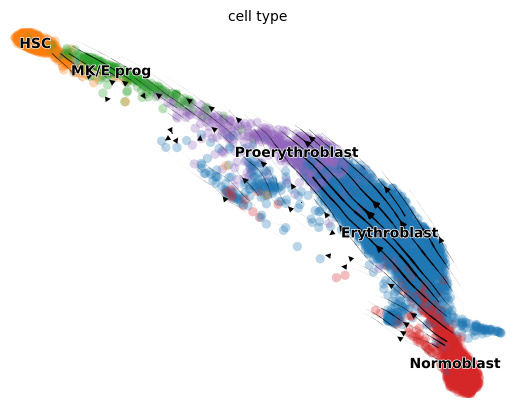

In [42]:
scv.tl.recover_dynamics(adata_bmmc)
scv.tl.velocity(adata_bmmc, mode='dynamical')
scv.tl.velocity_graph(adata_bmmc, n_jobs=1)
scv.pl.velocity_embedding_stream(adata_bmmc, basis='draw_graph_fa', color='cell_type')

In [43]:
cosines, euclids, dist_c, dist_s = get_metrics(bmmc_chrom_p_df, bmmc_x, bmmc_v, adata_bmmc.obsm['X_draw_graph_fa'], 
                                               adata_bmmc.obsm['velocity_draw_graph_fa'])
adata_bmmc.obs['cosine'] = cosines
adata_bmmc.obs['euclid'] = euclids
adata_bmmc.obs['dist_diff'] = (dist_c - dist_s).tolist()

Saved: figures/bmmc_d.svg


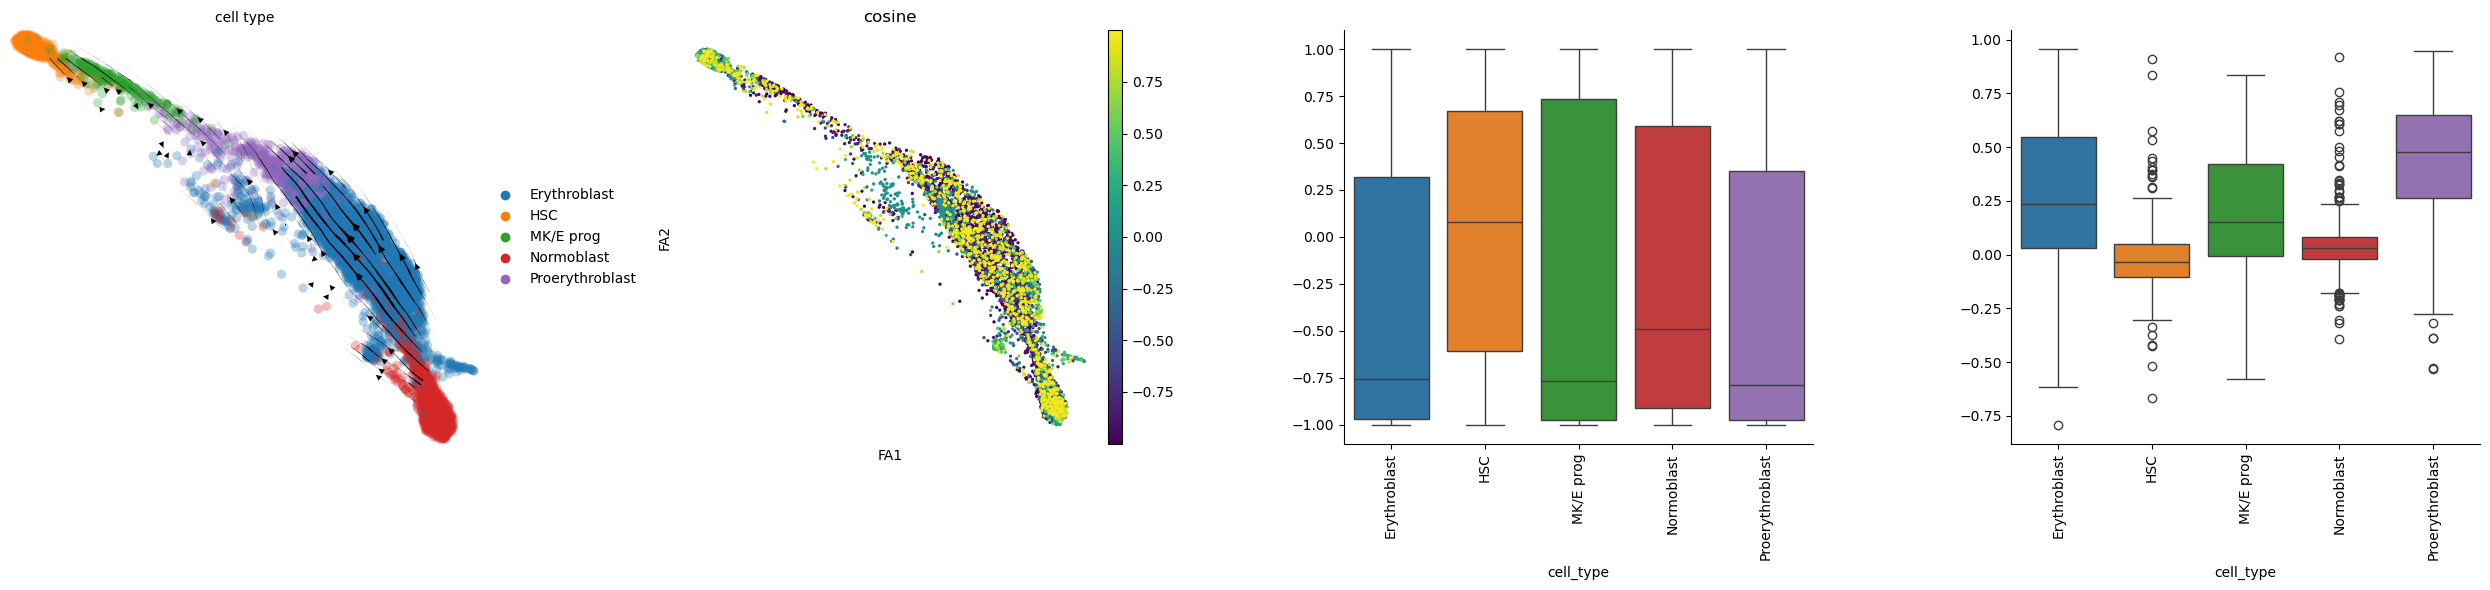

In [44]:
plot_metrics(adata_bmmc, basis='draw_graph_fa', celltype_col='cell_type', save='bmmc_d.svg')